# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no, changed in October by André Brodtkorb

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

import IPythonMagic

In [2]:
import pytest
from ipytest import run_tests, clean_tests

In [3]:
%setup_logging
%cuda_context_handler context

Python version 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Registering context in user workspace
Creating context
PyCUDA version 2018.1.1
CUDA version (9, 1, 0)
Driver version 10000
Using 'Tesla K80' GPU
 => compute capability: (3, 7)
 => memory: 11008 / 11441 MB available
Created context handle <51043040>
Using CUDA cache dir /home/ubuntu/jupyter_notebooks/Stefano Colombo/MilanoGPU2018/notebooks/cuda_cache


In [4]:
cuda_kernel = """
__global__ void matrixVectorKernel(float* c, float* A, float* b, int a_rows, int a_cols) {
    unsigned int j = blockIdx.x*blockDim.x + threadIdx.x;
    
    //Out of bounds check
    if (j > a_rows) {
        return;
    }
    
    //Compute inner product of row of A with column of B
    float sum = 0.0f;
    for (int i=0; i<a_cols; ++i) {
        unsigned int k = j*a_cols + i;
        sum += A[k] * b[i];
    }
    
    //Write to global memory
    c[j] = sum;
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("matrixVectorKernel");

In [5]:
def GPUMatrixVector(a, b):
    a_g = GPUArray(a.shape, np.float32)
    b_g = GPUArray(b.shape, np.float32)
    a.set(a)
    b.set(b)
    
    c_g = GPUArray(a.shape[0],npfloat32)
    #NOTE: We need to change this so that the grid*block is x = 1, y = number of rows in A
    block_size = (128, 1, 1) #These need to be [x, y, z]
    grid_size = (int(np.ceil(c.shape[0] / 128)), 1, 1)

    print("Block size is " + str(block_size))
    print("Grid size is " + str(grid_size))
    #Execute program on device
    kernel(c_g, a_g, b_g, np.int32(a.shape[0]), np.int32(a.shape[1]), block=block_size, grid=grid_size)
    
    c = np.empty((a.shape[0], 1), dtype=np.float32)
    
    #Copy data from device to host
    c_g.get(c)
    return c


In [6]:
#Size of our test
test_size = (4, 3)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random((test_size[1], 1)).astype(np.float32)
c = GPUMatrixVector(a, b)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(a)
plt.subplot(1,3,2)
plt.imshow(b)
plt.subplot(1,3,3)
plt.imshow(c)
fig.show()

Exception caught: Resetting to CUDA context context
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-1d1ec5b1d9ad>", line 7, in <module>
    c = GPUMatrixVector(a, b)
  File "<ipython-input-5-2c5a11d49a17>", line 4, in GPUMatrixVector
    a.set(a)
AttributeError: 'numpy.ndarray' object has no attribute 'set'
Popping <51043040>
Pushing <51043040>


---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self, code_obj, result, async_)
   3264                 else:
-> 3265                     exec(code_obj, self.user_global_ns, self.user_ns)
   3266             finally:

<ipython-input-6-1d1ec5b1d9ad> in <module>
      6 b = np.random.random((test_size[1], 1)).astype(np.float32)
----> 7 c = GPUMatrixVector(a, b)
      8 

<ipython-input-5-2c5a11d49a17> in GPUMatrixVector(a, b)
      3     b_g = GPUArray(b.shape, np.float32)
----> 4     a.set(a)
      5     b.set(b)

AttributeError: 'numpy.ndarray' object has no attribute 'set'

During handling of the above exception, another exception occurred:

NameError                                 Traceback (most recent call last)
~/jupyter_notebooks/Stefano Colombo/MilanoGPU2018/notebooks/IPythonMagic.py in custom_e

Custom TB Handler failed, unregistering


In [23]:
#Compute reference using Numpy
c_ref = np.dot(a, b)

#Sum of absolute differences
sad = np.sum(np.abs(c - c_ref))

#Print result
# print("C   = ", c)
# print("Ref = ", c_ref)
print("Sad = %.30f" % sad)
print("Per element error: " + str(sad / test_size[1]))

Sad =  0.00023651123
Per element error: 3.196097709037162e-06


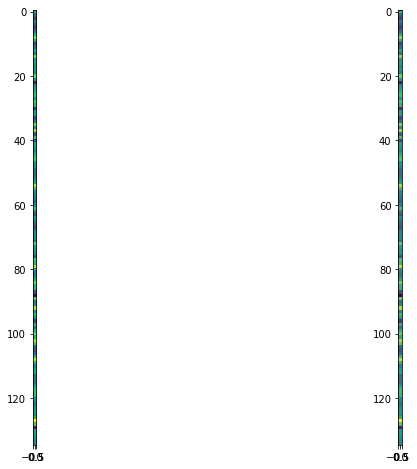

In [20]:
clean_tests()

def test_GPUMatrixVector():
    #let us test a matrix of size 1x1
    a = np.ones((1, 1), dtype=np.float32)
    b = 2*np.ones((1, 1), dtype=np.float32)
    c = GPUMatrixVector(a, b)
    assert c == pytest.approx(2.0)
    
    #Test that the inner product works
    a = np.ones((1, 2), dtype=np.float32)
    b = 2*np.ones((2, 1), dtype=np.float32)
    c = GPUMatrixVector(a, b)
    assert c == pytest.approx(4.0)     
    
    #Test a general matrix
    test_size = (4, 3)
    a = np.random.random(test_size).astype(np.float32)
    b = np.random.random((test_size[1], 1)).astype(np.float32)
    c = GPUMatrixVector(a, b)
    assert c == pytest.approx(np.dot(a, b))
    
    
run_pytests(filename='MatrixVectorTesting', pytest_options=['-vvv'])